# Segmentación de Imágenes con Segment Anything Model (SAM)

Este notebook demuestra cómo usar el Segment Anything Model (SAM) para segmentar una imagen. Usaremos una imagen de una calle en Cuenca, Ecuador, para mostrar las capacidades de SAM.

## 1. Configuración e Importaciones

Primero, instalaremos e importaremos las librerías necesarias. Esto incluye `segment-anything` de su repositorio de GitHub, junto con `torch`, `torchvision`, `matplotlib` y `opencv-python`.

pip install git+https://github.com/facebookresearch/segment-anything.git

pip install torch torchvision matplotlib opencv-python

In [18]:
import torch
import torchvision
import matplotlib.pyplot as plt
import cv2
import numpy as np
from segment_anything import sam_model_registry, SamPredictor

## Descargar el Checkpoint de SAM

Ahora, descargaremos el checkpoint del modelo pre-entrenado de SAM. Usaremos el modelo `vit_h`, que es la versión más grande y precisa.

https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [19]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

## 4. Cargar y Preparar la Imagen

Cargaremos la imagen objetivo `../data/Street_in_Cuenca,_Ecuador.jpg` usando OpenCV. Convertiremos la imagen de BGR (el formato por defecto de OpenCV) a RGB, como espera el modelo SAM. Luego, estableceremos la imagen para el predictor.

In [20]:
image = cv2.imread('../data/calle_cuenca.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor.set_image(image)

KeyboardInterrupt: 

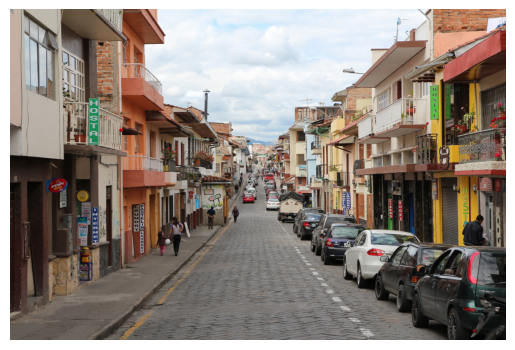

In [ ]:
# plot my image 
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
#tamano de la imagen
H, W, _ = image.shape

print(f"Altura: {H}, Ancho: {W}")

Altura: 3456, Ancho: 5184


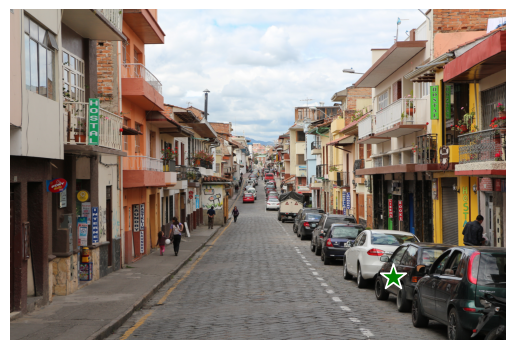

In [ ]:
#punto para segmentar
input_point = np.array([[4000, 2800]])

#plot mi punto en la imagen
plt.imshow(image)
plt.scatter(input_point[0][0], input_point[0][1], color='green', marker='*', s=375, edgecolor='white', linewidth=1.25)
plt.axis('off')
plt.show()

## 5. Generar Máscara de Segmentación

Definiremos un punto de entrada y una etiqueta correspondiente para especificar el objeto a segmentar. Usaremos el método `predict` del `SamPredictor` para generar las máscaras de segmentación, las puntuaciones de calidad y los logits basados en el prompt de entrada.

In [ ]:
input_point = np.array([[4000, 2800]])
input_label = np.array([1])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

## 6. Visualizar la Segmentación

Crearemos una función auxiliar para mostrar los resultados. Usaremos Matplotlib para mostrar la imagen original con la máscara predicha superpuesta y el punto de entrada marcado.

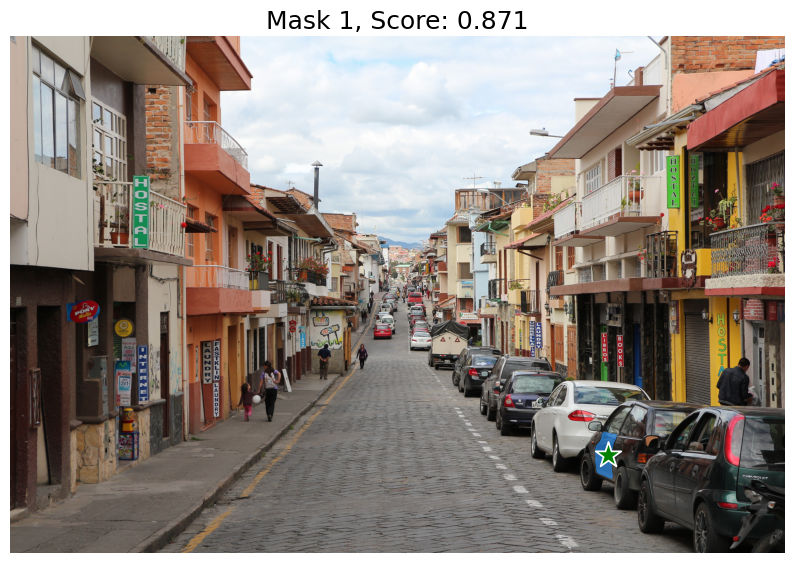

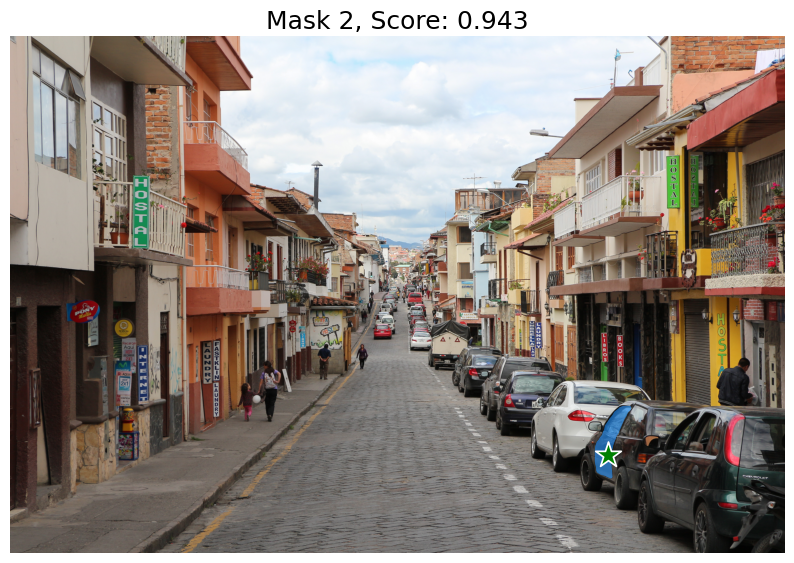

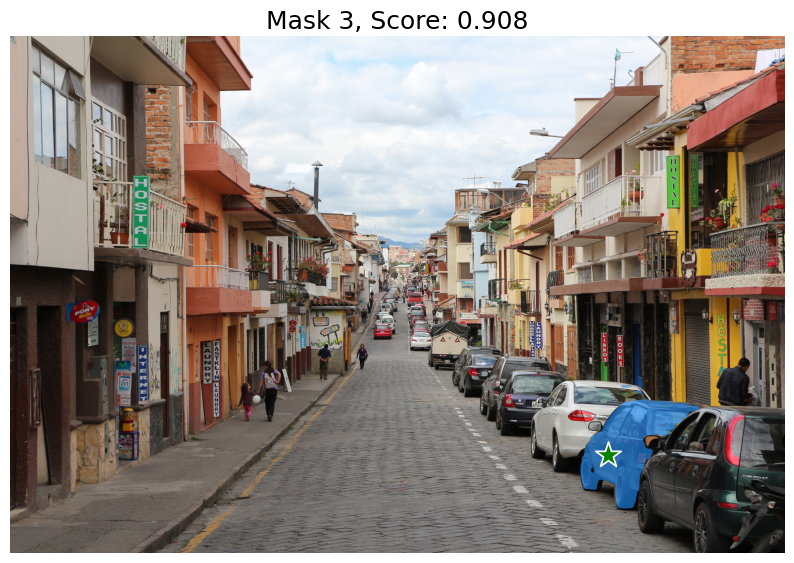

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')

## 7. Detección y Segmentación de Múltiples Objetos (Coches)

Para segmentar todos los coches en la imagen, primero necesitamos detectarlos. Usaremos un modelo de detección de objetos pre-entrenado de `torchvision` para encontrar las ubicaciones de todos los coches. Luego, pasaremos los cuadros delimitadores (bounding boxes) de esos coches a SAM para generar sus máscaras de segmentación.


In [24]:
# Cargar un modelo de detección de objetos pre-entrenado
detection_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
detection_model.to(device)
detection_model.eval()

# Clases de COCO que el modelo puede detectar
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Función para obtener la predicción
def get_prediction(img, model, threshold):
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    img = transform(img).to(device)
    pred = model([img])
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    
    # Find scores above the threshold
    scores_above_threshold = [score for score in pred_score if score > threshold]
    if not scores_above_threshold:
        return [], [], []

    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    pred_score = pred_score[:pred_t+1]
    return pred_boxes, pred_class, pred_score


# Obtener las predicciones para la imagen
boxes, pred_cls, pred_scores = get_prediction(image, detection_model, 0.7)

# Filtrar solo los coches
car_boxes = [box for box, cls in zip(boxes, pred_cls) if cls == 'car']
car_scores = [score for score, cls in zip(pred_scores, pred_cls) if cls == 'car']

print(f"Se encontraron {len(car_boxes)} coches en la imagen.")

Se encontraron 14 coches en la imagen.


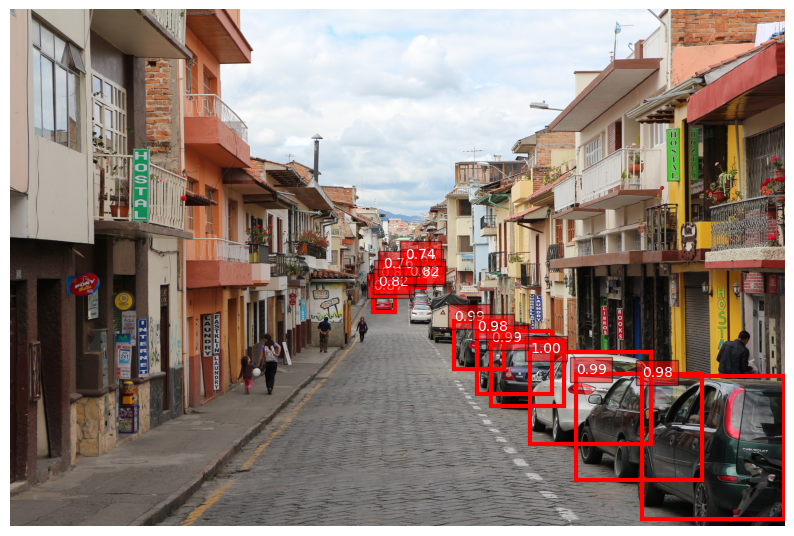

In [25]:

#plot the detected cars
plt.figure(figsize=(10,10))
plt.imshow(image)

for box, score in zip(car_boxes, car_scores):
    plt.gca().add_patch(plt.Rectangle(box[0],
                                      box[1][0]-box[0][0],
                                      box[1][1]-box[0][1],
                                      fill=False,
                                      color='red',
                                      linewidth=3))
    plt.text(box[0][0], box[0][1], f'{score:.2f}', bbox=dict(facecolor='red', alpha=0.5), fontsize=10, color='white')
    
    

plt.axis('off')
plt.show()

Ahora que tenemos los cuadros delimitadores para cada coche, podemos usar SAM para generar una máscara para cada uno.


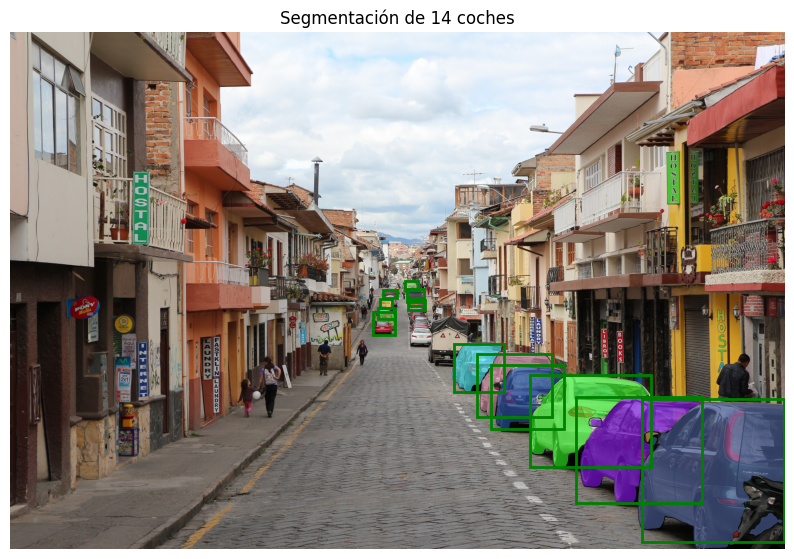

In [ ]:
# Función para mostrar los cuadros delimitadores
def show_box(box, ax):
    x0, y0 = box[0]
    x1, y1 = box[1]
    ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

# Establecer la imagen en el predictor de SAM
predictor.set_image(image)

# Convertir los cuadros delimitadores al formato que espera SAM
input_boxes = torch.tensor(car_boxes, device=predictor.device)

# Predecir las máscaras para todos los cuadros delimitadores
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

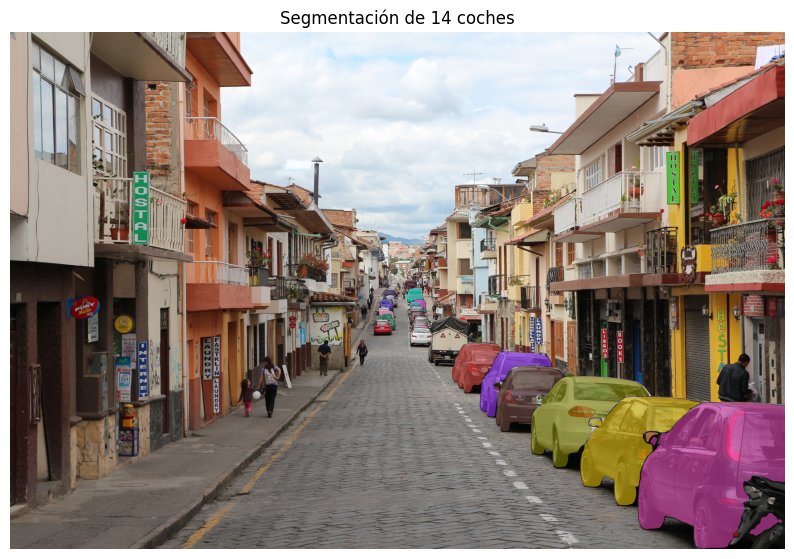

In [27]:
# Visualizar las máscaras y los cuadros delimitadores
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)

plt.title(f"Segmentación de {len(car_boxes)} coches")
plt.axis('off')
plt.show()
